<a href="https://colab.research.google.com/github/dipankarsrirag/Dialogue-Summarisation/blob/main/notebooks/Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Comparative Analysis of Dialogue Summarization: Seq2Seq Transformer vs. Advanced Architectures like BART and T5

**Group Name: Able Elba**

|       Name      | Email Address | Student ID|
|-----------------|---------------|-----------|
| Dipankar Srirag | z5437514@ad.unsw.edu.au | z5437514 |
| Pratyush Ravindrakumar Panda | z5410294@ad.unsw.edu.au | z5410294 |
|Pinak Sharma|z5311106@ad.unsw.edu.au|z5311106|
|Kazi Mahibul Hasan|z5359206@ad.unsw.edu.au|z5359206|
|Serkan Akin|z5519653@ad.unsw.edu.au|z5519653|




## Table of Contents

1. [Introduction](##Introduction)
    - [Motivation](###Motivation)
    - [Problem Statement](###Problem-Statement)
2. [Data Sources](##DataSources)
3. [Methodology](#Methodology)
    - [Dataset Description](#Dataset-Description)
    - [Model Architecture](#Model-Architecture)
        - [Seq2Seq Transformer](#Seq2Seq-Transformer)
        - [BART](#BART)
        - [T5](#T5)
    - [Training Approach](#Training-Approach)
4. [Experiment and Results](#Experiment-and-Results)
    - [Experimental Setup](#Experimental-Setup)
    - [Performance Metrics](#Performance-Metrics)
    - [Results Analysis](#Results-Analysis)
5. [Discussion](#Discussion)
    - [Model Comparison](#Model-Comparison)
    - [Implications](#Implications)
6. [Conclusion](#Conclusion)
    - [Summary of Findings](#Summary-of-Findings)
    - [Future Work](#Future-Work)
7. [References](#References)
8. [Appendix](#Appendix)
    - [Code](#Code)
    - [Additional Data](#Additional-Data)

## Introduction

This project aims to conduct a comprehensive comparative analysis of different approaches to dialog summarization, focusing on the effectiveness of a static embedding-based Seq2Seq Transformer model against more complex transformer architectures, such as BART and T5.

### Problem Statement:
Dialog summarization is an essential aspect of Natural Language Processing (NLP), aimed at condensing conversations or dialogues into concise summaries without losing the context or essential information. The challenge lies in accurately capturing the nuances and key points of dialogues, which can be complex and multi-threaded. This project seeks to understand and evaluate how different model architectures - particularly, a simpler Seq2Seq Transformer with static embeddings versus more advanced and dynamic models like BART (Bidirectional and Auto-Regressive Transformers) and T5 (Text-to-Text Transfer Transformer) - perform in the task of dialog summarization.

### Motivation

The motivation for this comparative study of dialogue summarization models stems from a keen interest in exploring the capabilities of different embedding techniques within transformer architectures, particularly focusing on the contrast between static embeddings and context-aware embeddings.

1. **Exploration of Static vs. Context-Aware Embeddings:** This project is driven by a curiosity to understand how static embeddings, like GloVe, which are pre-trained on large corpora but lack contextual sensitivity, perform in comparison to the dynamic, context-aware embeddings used in advanced models like BART and T5. While context-aware embeddings are designed to adapt to the specific nuances of the input text, static embeddings offer a fixed representation of words irrespective of their context. This investigation seeks to unravel how these fundamentally different approaches to language understanding affect the quality of dialog summarization.

2. **Contributing to the Understanding of Embedding Technologies:** Through this exploratory study, there is an opportunity to contribute valuable findings to the field of NLP regarding the efficacy of different embedding technologies. The results of this comparison could inform future research and development in NLP, particularly in the selection and optimization of embedding techniques for various language processing tasks.

In summary, this project is driven by a genuine curiosity to explore and understand the performance dynamics of static and context-aware embeddings in dialogue summarization, thereby enriching our understanding of embedding technologies in NLP, and assist researchers and practitioners in choosing the most suitable model for their specific needs and constraints.

## Data Sources

For this project, we are utilizing the DialogSum dataset, a comprehensive and large-scale dialogue summarization resource. This dataset encompasses 13,460 dialogues, each paired with manually labeled summaries and topics, providing a robust foundation for our study. The following details offer a clear guide to accessing and understanding this dataset:

1. **Primary Source:** The DialogSum dataset is available through its original repository, which can be found at [DialogSum GitHub Repository](https://github.com/cylnlp/DialogSum). This source is used to construct a custom pipeline for our seq2seq model.

2. **Secondary Source for Pretrained Models:** For the purpose of fine-tuning the pretrained models like BART and T5, the DialogSum dataset is also accessible via the Hugging Face Datasets library, specifically at [DialogSum on Hugging Face](https://huggingface.co/datasets/knkarthick/dialogsum). This version is tailored for integration with pretrained models.

3. **Dataset Characteristics:** DialogSum stands out from other dialogue datasets, such as SAMSUM, due to its meticulous preprocessing. This preprocessing includes the correction of grammatical errors in the dialogues and the provision of well-annotated summaries in formal language. Such refinement enhances the dataset's utility for our project. The dataset also provides a hidden test set to perform summarisation on completely new unnanotated dialogues.

4. **Empirical Study Reference:** An empirical study assessing the performance of Large Language Models (LLMs) on the DialogSum dataset is detailed in the corresponding [research paper](https://aclanthology.org/2021.findings-acl.449.pdf). This paper offers valuable insights and benchmarks that can inform and guide our analysis.

By leveraging the DialogSum dataset from these specified sources, our project is positioned to conduct a thorough and informed comparison of the Seq2Seq Transformer model with static embeddings against advanced models like BART and T5, which employ context-aware embeddings.

**Installing libraries to the environment**

In [1]:
!pip install -U transformers &> /dev/null
!pip install -U accelerate &> /dev/null
!pip install -U datasets &> /dev/null
!pip install -U bertviz &> /dev/null
!pip install -U umap-learn &> /dev/null
!pip install -U sentencepiece &> /dev/null
!pip install -U urllib3 &> /dev/null
!pip install py7zr &> /dev/null
!pip install rouge_score &> /dev/null

**Importing Libraries**

In [4]:
from __future__ import unicode_literals, print_function, division

import json
import math
import time
from collections import Counter
from io import open

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from datasets import load_dataset, load_metric
from gensim.models import KeyedVectors
from google.colab import drive
from IPython.display import display, HTML
from nltk import FreqDist
from nltk.tokenize import WordPunctTokenizer
from nltk.translate.bleu_score import sentence_bleu
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from torch.utils.data import DataLoader, RandomSampler, TensorDataset
from tqdm.auto import tqdm
from transformers import (AutoModelForSeq2SeqLM, AutoTokenizer, DataCollatorForSeq2Seq,
                          Trainer, TrainingArguments)
import warnings

nltk.download('punkt')

warnings.filterwarnings('ignore')
plt.switch_backend('agg')

MAX_LENGTH = 200
INDICES = [3, 43, 81]

drive.mount('/content/drive')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
%matplotlib inline


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Mounted at /content/drive


## Exploring Data
### Basic Descriptive Statistics

In [5]:
# Load the training data
train_df = pd.read_json('/content/drive/My Drive/COMP9444/data/raw/dialogsum/dialogsum.train.jsonl',
                        lines=True)[['dialogue', 'summary']]
train_df['Dialogue Length'] = train_df['dialogue'].apply(lambda x: len(x.split()))
train_df['Summary Length'] = train_df['summary'].apply(lambda x: len(x.split()))
train_stats = train_df[['Dialogue Length', 'Summary Length']].describe()

# Load the development data
dev_df = pd.read_json('/content/drive/My Drive/COMP9444/data/raw/dialogsum/dialogsum.dev.jsonl',
                      lines=True)[['dialogue', 'summary']]
dev_df['Dialogue Length'] = dev_df['dialogue'].apply(lambda x: len(x.split()))
dev_df['Summary Length'] = dev_df['summary'].apply(lambda x: len(x.split()))
dev_stats = dev_df[['Dialogue Length', 'Summary Length']].describe()

# Combine the statistics
combined_stats = pd.concat([train_stats, dev_stats], axis=1, keys=['Train', 'Dev'])

# Format and display the combined DataFrame
formatted_combined_stats = combined_stats.style.set_table_styles([
    {'selector': 'th', 'props': [('font-size', '12pt')]},
    {'selector': 'table', 'props': [('margin-left', 'auto'), ('margin-right', 'auto')]}  # Centering the table
]).set_properties(**{'text-align': 'center'})  # Centering the text

formatted_combined_stats

### Plotting Descriptive Statistics

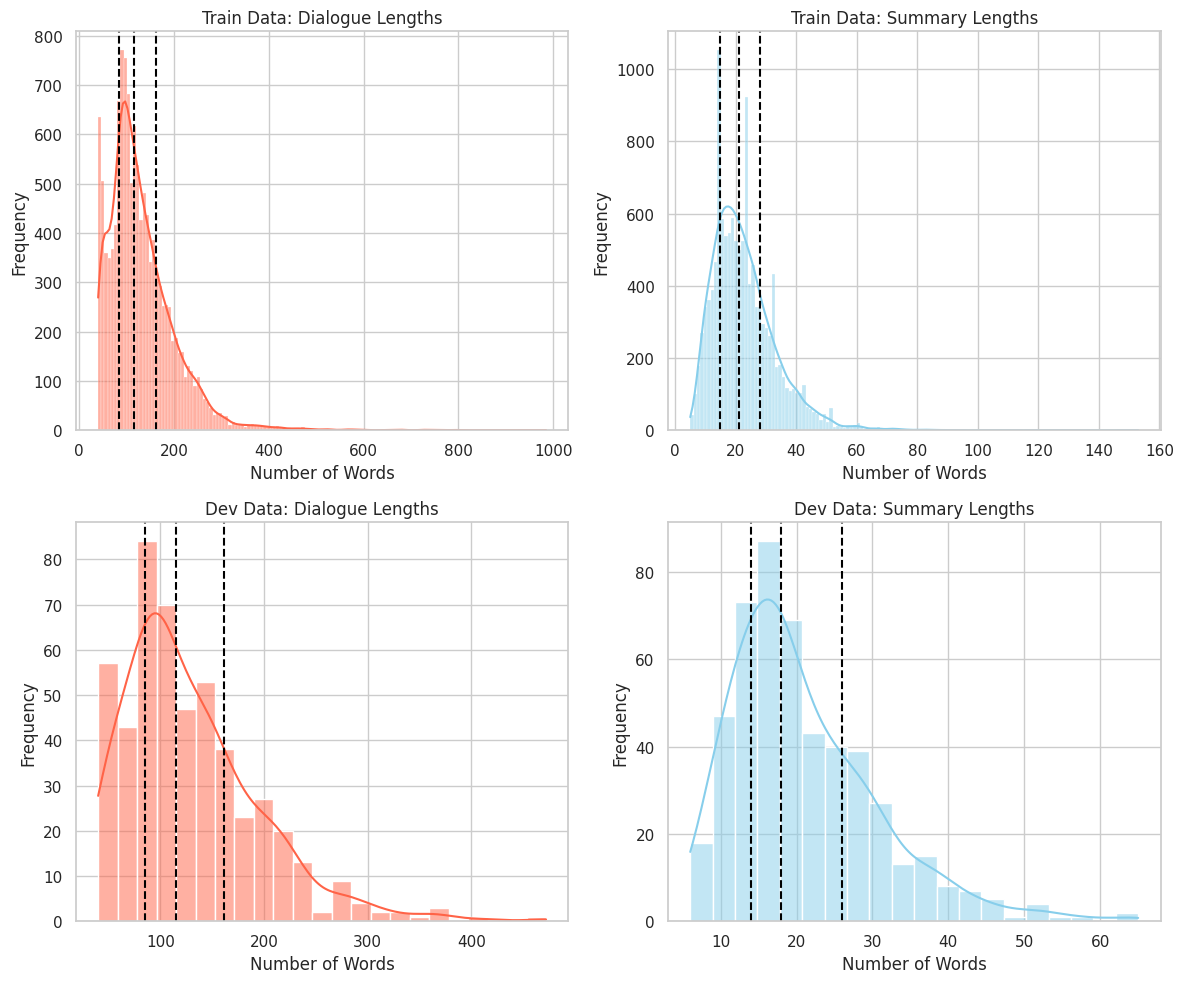

In [6]:
# Calculate quantiles
quantiles_dialogue_train = train_df['Dialogue Length'].quantile([0.25, 0.5, 0.75])
quantiles_summary_train = train_df['Summary Length'].quantile([0.25, 0.5, 0.75])

quantiles_dialogue_dev = dev_df['Dialogue Length'].quantile([0.25, 0.5, 0.75])
quantiles_summary_dev = dev_df['Summary Length'].quantile([0.25, 0.5, 0.75])

# Plotting
sns.set(style="whitegrid", palette="pastel")
plt.figure(figsize=(12, 10))

# Subplots for Training Data
plt.subplot(2, 2, 1)
sns.histplot(train_df['Dialogue Length'], kde=True, color='tomato')
plt.title('Train Data: Dialogue Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
for quantile in quantiles_dialogue_train:
    plt.axvline(quantile, color='black', linestyle='--')

plt.subplot(2, 2, 2)
sns.histplot(train_df['Summary Length'], kde=True, color='skyblue')
plt.title('Train Data: Summary Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
for quantile in quantiles_summary_train:
    plt.axvline(quantile, color='black', linestyle='--')

# Subplots for Development Data
plt.subplot(2, 2, 3)
sns.histplot(dev_df['Dialogue Length'], kde=True, color='tomato')
plt.title('Dev Data: Dialogue Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
for quantile in quantiles_dialogue_dev:
    plt.axvline(quantile, color='black', linestyle='--')

plt.subplot(2, 2, 4)
sns.histplot(dev_df['Summary Length'], kde=True, color='skyblue')
plt.title('Dev Data: Summary Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
for quantile in quantiles_summary_dev:
    plt.axvline(quantile, color='black', linestyle='--')

plt.tight_layout()
plt.show()

**COMMENTS**

### Most Common Words

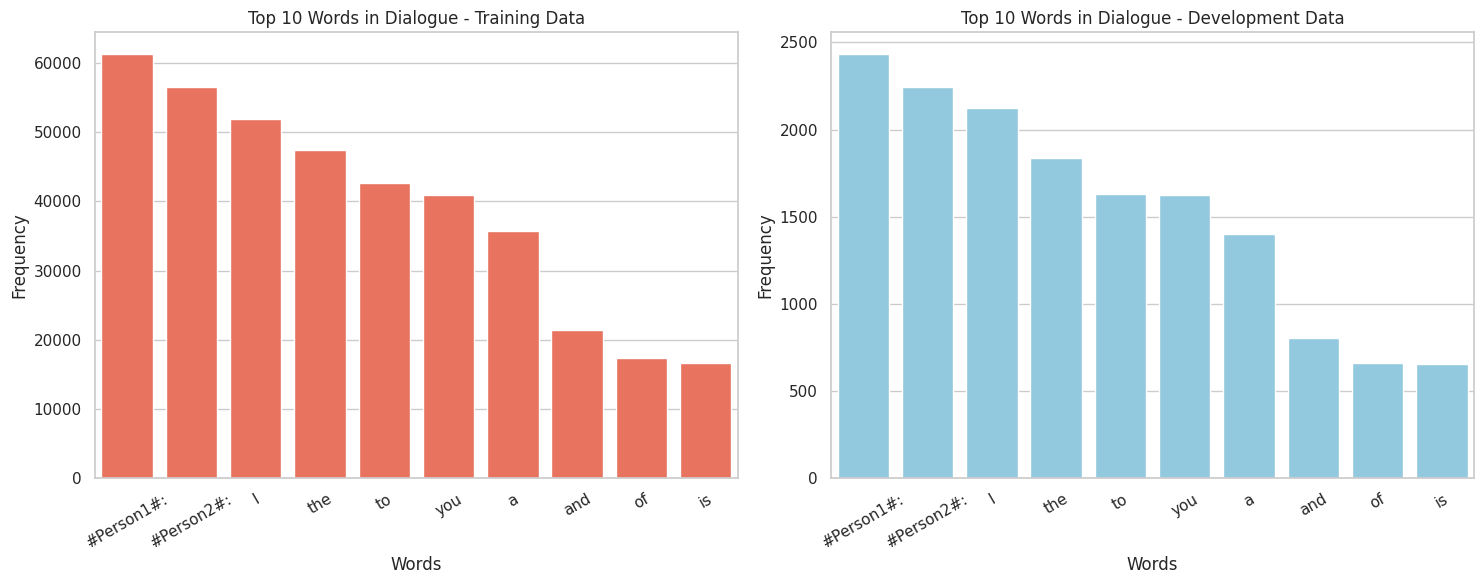

In [7]:
word_counts_train = Counter(" ".join(train_df['dialogue']).split())
most_common_words_train = word_counts_train.most_common(10)
words_train, counts_train = zip(*most_common_words_train)

# Count word frequencies for the development dataset
word_counts_dev = Counter(" ".join(dev_df['dialogue']).split())
most_common_words_dev = word_counts_dev.most_common(10)
words_dev, counts_dev = zip(*most_common_words_dev)

# Plotting
sns.set(style="whitegrid", palette="pastel")
plt.figure(figsize=(15, 6))

# Subplot for Training Data
plt.subplot(1, 2, 1)
sns.barplot(x=list(words_train), y=list(counts_train), color="tomato")
plt.title('Top 10 Words in Dialogue - Training Data')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=30)

# Subplot for Development Data
plt.subplot(1, 2, 2)
sns.barplot(x=list(words_dev), y=list(counts_dev), color="skyblue")
plt.title('Top 10 Words in Dialogue - Development Data')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=30)

plt.tight_layout()
plt.show()

**COMMENTS**

### Uni-gram Overlap

In [8]:
def unigram_overlap(row):
    dialogue_words = set(row['dialogue'].split())
    summary_words = set(row['summary'].split())
    overlap = summary_words.intersection(dialogue_words)
    return len(overlap) / len(summary_words) * 100 if summary_words else 0

# Apply the function and calculate average for train_df
train_df['unigram_overlap'] = train_df.apply(unigram_overlap, axis=1)
avg_overlap_train = train_df['unigram_overlap'].mean()

# Apply the function and calculate average for dev_df
dev_df['unigram_overlap'] = dev_df.apply(unigram_overlap, axis=1)
avg_overlap_dev = dev_df['unigram_overlap'].mean()

# Create a styled DataFrame for display
results_df = pd.DataFrame({
    "Dataset": ["Training Set", "Development Set"],
    "Average Unigram Overlap (%)": [avg_overlap_train, avg_overlap_dev]
}).style.hide(axis="index")

# Display the styled DataFrame
display(results_df)

Dataset,Average Unigram Overlap (%)
Training Set,48.060675
Development Set,45.961782


**COMMENTS**

### Most Common Bi-grams

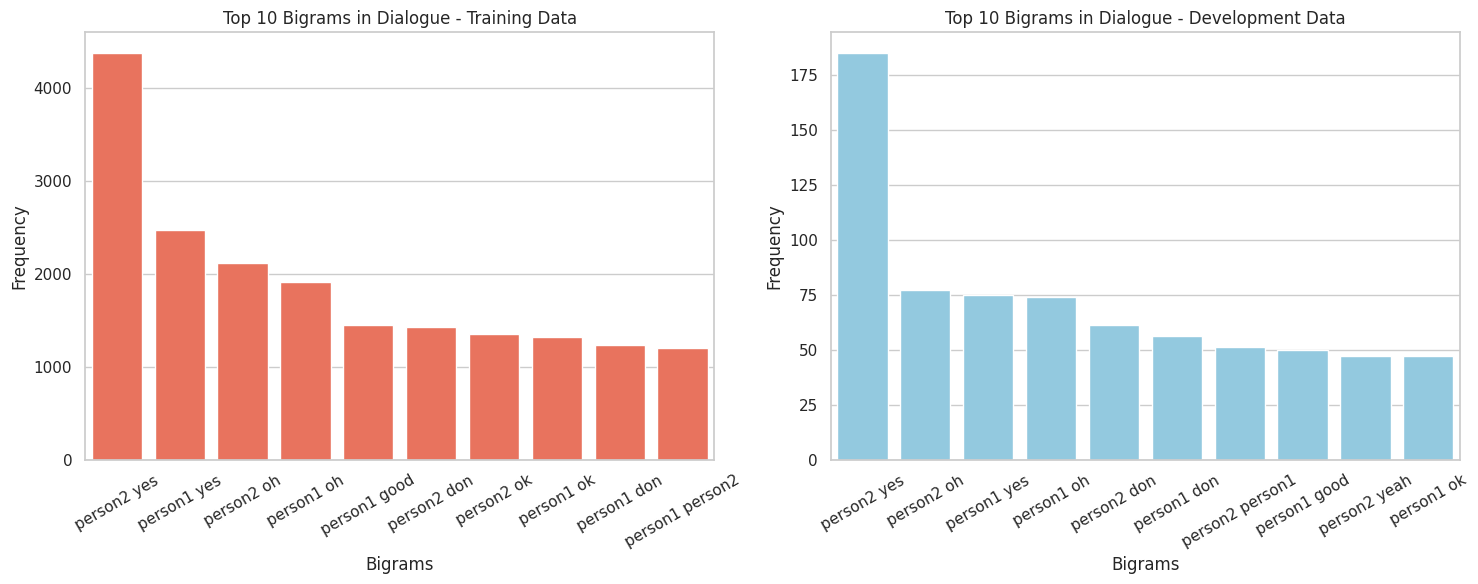

In [9]:
def get_top_ngrams(corpus, n=None, ngram=2):
    vec = CountVectorizer(ngram_range=(ngram, ngram), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

# Get top bigrams for training data
top_bigrams_train = get_top_ngrams(train_df['dialogue'], n=10, ngram=2)
bigrams_train, bigram_freqs_train = zip(*top_bigrams_train)

# Get top bigrams for development data
top_bigrams_dev = get_top_ngrams(dev_df['dialogue'], n=10, ngram=2)
bigrams_dev, bigram_freqs_dev = zip(*top_bigrams_dev)

# Plotting
sns.set(style="whitegrid", palette="pastel")
plt.figure(figsize=(15, 6))

# Subplot for Training Data
plt.subplot(1, 2, 1)
sns.barplot(x=list(bigrams_train), y=list(bigram_freqs_train), color="tomato")
plt.title('Top 10 Bigrams in Dialogue - Training Data')
plt.xlabel('Bigrams')
plt.ylabel('Frequency')
plt.xticks(rotation=30)

# Subplot for Development Data
plt.subplot(1, 2, 2)
sns.barplot(x=list(bigrams_dev), y=list(bigram_freqs_dev), color="skyblue")
plt.title('Top 10 Bigrams in Dialogue - Development Data')
plt.xlabel('Bigrams')
plt.ylabel('Frequency')
plt.xticks(rotation=30)

plt.tight_layout()
plt.show()

**COMMENTS**

**Loading Test Set and Hidden Set**

In [10]:
test_df = pd.read_json("/content/drive/MyDrive/COMP9444/data/raw/dialogsum/dialogsum.test.jsonl", lines = True)[['dialogue', 'summary1']]
test_df.columns = ['dialogue', 'summary']
test_dialogues, references = list(test_df['dialogue']), list(test_df['summary'])

hidden_dialogues = list(pd.read_json('/content/drive/My Drive/COMP9444/data/raw/dialogsum/dialogsum.hiddentest.dialogue.jsonl', lines = True)['dialogue'])


## Methods
**WHATS BEEN DONE**

**Helper functions**

In [11]:
def get_feature(batch, tokenizer):
  encodings = tokenizer(batch['dialogue'], text_target=batch['summary'],
                        max_length=1024, truncation=True)

  encodings = {'input_ids': encodings['input_ids'],
               'attention_mask': encodings['attention_mask'],
               'labels': encodings['labels']}

  return encodings

def generate_summaries(texts, model, tokenizer, device, progress = True):
    model.to(device)
    model.eval()
    summaries = []
    if progress:
        iterator = tqdm(texts)
    else:
        iterator = texts
    for text in iterator:
        with torch.no_grad():
            inputs = tokenizer(text, return_tensors="pt", max_length=1024, truncation=True).to(device)
            summary_ids = model.generate(inputs['input_ids'], attention_mask=inputs['attention_mask'])
            summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
            summaries.append(summary)

    return summaries

def generate_metrics(references, summaries):
    total_rouge_scores = {key: 0 for key in ['rouge1', 'rouge2', 'rougeL', 'rougeLsum']}
    total_bleu_score = 0

    rouge_metric = load_metric('rouge')

    for reference, summary in tqdm(zip(references, summaries), total=len(references)):

        # Calculate ROUGE scores
        rouge_score = rouge_metric.compute(predictions=[summary], references=[reference])

        # Aggregate ROUGE scores
        for key in total_rouge_scores.keys():
            total_rouge_scores[key] += rouge_score[key].mid.fmeasure

        # Calculate BLEU score
        bleu_score = sentence_bleu([nltk.word_tokenize(reference)], nltk.word_tokenize(summary))
        total_bleu_score += bleu_score

    # Average the scores
    scores = {}
    for k, v in total_rouge_scores.items():
        scores[k] = scores.get(k, 0) + v/len(test_dialogues)

    avg_bleu_score = total_bleu_score / len(test_dialogues)
    scores = list(scores.values())
    scores.append(avg_bleu_score)
    return scores


def print_summaries(model_1, model_2, token_1, token_2, indices, device, hidden=True):
    for i, idx in enumerate(indices):
        print(f'[DIALOGUE #{i+1}]')

        if hidden:
            print(hidden_dialogues[idx])
            print('--------------------')
            print('[SUMMARY A]')
            print(generate_summaries([hidden_dialogues[idx]], model_1, token_1, device, False)[0])
            print('--------------------')

            print('[SUMMARY B]')
            print(generate_summaries([hidden_dialogues[idx]], model_2, token_2, device, False)[0])
        else:
            print(test_dialogues[idx])
            print('--------------------')
            print('[ORIGINAL SUMMARY]')
            print(references[idx])
            print('--------------------')


            print('[SUMMARY A]')
            print(generate_summaries([test_dialogues[idx]], model_1, token_1, device, False)[0])
            print('--------------------')

            print('[SUMMARY B]')
            print(generate_summaries([test_dialogues[idx]], model_2, token_2, device, False)[0])
        print('####################')


### BART
**WHAT IS BART**
**WHY CHOOSE THIS**
#### Pretrained
**HOW HAS IT BEEN PRETRAINED**

In [12]:
model_ckpt = 'facebook/bart-base'
bart_tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
bart_model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt)
save_ckpt = '/content/drive/My Drive/COMP9444/models/BART/'

**Generating Summaries and Evaluating Pretrained model**

In [13]:
bart_metrics = dict()
bart_pretrained_summaries = generate_summaries(test_dialogues, bart_model, bart_tokenizer, device)
bart_metrics['Pre Trained'] = generate_metrics(references, bart_pretrained_summaries)

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

####Finetuned

**Prepare data using a collator**

In [14]:
diasum = load_dataset('knkarthick/dialogsum')
diasum_pt = diasum.map(get_feature, batched=True, fn_kwargs={'tokenizer': bart_tokenizer})
diasum_pt.set_format('torch', columns=['input_ids', 'labels', 'attention_mask'])
data_collator = DataCollatorForSeq2Seq(bart_tokenizer, model=bart_model)

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/12460 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

**Setting up hyperparameters**

In [16]:
batch_size = 4
training_args = TrainingArguments(
    output_dir = 'bart_finetuned',
    overwrite_output_dir = True,
    num_train_epochs=3,
    learning_rate=3e-5,
    warmup_steps = 200,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay = 0.01,
    logging_steps = 0.1,
    evaluation_strategy = 'steps',
    eval_steps=50,
    save_steps=1e6,
    gradient_accumulation_steps=16,
)

bart_trainer = Trainer(model=bart_model, args=training_args, tokenizer=bart_tokenizer, data_collator=data_collator,
                  train_dataset = diasum_pt['train'], eval_dataset = diasum_pt['validation'])

**Retrain BART**

In [17]:
bart_trainer.train()

You're using a BartTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss
50,No log,2.180019
100,3.142900,1.514253
150,1.887700,1.427490
200,1.655500,1.379973
250,1.551500,1.347724
300,1.506300,1.312062
350,1.506300,1.282431
400,1.450200,1.273645
450,1.429700,1.261573
500,1.374300,1.235757


TrainOutput(global_step=582, training_loss=1.673529516790331, metrics={'train_runtime': 684.8594, 'train_samples_per_second': 54.581, 'train_steps_per_second': 0.85, 'total_flos': 7109069800734720.0, 'train_loss': 1.673529516790331, 'epoch': 2.99})

**Saving the best model**

In [18]:
bart_trainer.save_model(save_ckpt)

**Clearing GPU cache**

In [19]:
torch.cuda.empty_cache()
del bart_trainer
del bart_model
del bart_tokenizer

**Generating Summaries and Evaluating Fine-tuned model**

In [20]:
bart_fine_tokenizer = AutoTokenizer.from_pretrained(save_ckpt)
bart_fine_model = AutoModelForSeq2SeqLM.from_pretrained(save_ckpt)

bart_finetuned_summaries = generate_summaries(test_dialogues, bart_fine_model, bart_fine_tokenizer, device)
bart_metrics['Fine Tuned'] = generate_metrics(references, bart_finetuned_summaries)

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [21]:
bart_tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
bart_model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt)

#### Quantitaive Analysis

In [22]:
bart_metrics = pd.DataFrame(bart_metrics).T
bart_metrics.columns = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'ROUGE-LSum', 'BLEU']
bart_metrics

,ROUGE-1,ROUGE-2,ROUGE-L,ROUGE-LSum,BLEU
Pre Trained,0.214983,0.045041,0.186183,0.186183,0.009860
Fine Tuned,0.384703,0.154293,0.329394,0.329394,0.089667


**COMMENTS ON WHY QUANTITATIVE IS NOT RELIABLE**

#### Qualitative Analysis
**Printing Test Set Summaries**

In [23]:
print_summaries(bart_model, bart_fine_model, bart_tokenizer, bart_fine_tokenizer, INDICES, device, False)

[DIALOGUE #1]
#Person1#: Happy Birthday, this is for you, Brian.
#Person2#: I'm so happy you remember, please come in and enjoy the party. Everyone's here, I'm sure you have a good time.
#Person1#: Brian, may I have a pleasure to have a dance with you?
#Person2#: Ok.
#Person1#: This is really wonderful party.
#Person2#: Yes, you are always popular with everyone. and you look very pretty today.
#Person1#: Thanks, that's very kind of you to say. I hope my necklace goes with my dress, and they both make me look good I feel.
#Person2#: You look great, you are absolutely glowing.
#Person1#: Thanks, this is a fine party. We should have a drink together to celebrate your birthday
--------------------
[ORIGINAL SUMMARY]
#Person1# and Brian are at the birthday party of Brian. Brian thinks #Person1# looks great and is popular.
--------------------
[SUMMARY A]
#Person1#: Happy Birthday, this is for you, Brian.#Person
--------------------
[SUMMARY B]
Brian invites #Person1# to have a dance at his 

**COMMENTS**

**Printing Hidden Set Summaries**

In [24]:
print_summaries(bart_model, bart_fine_model, bart_tokenizer, bart_fine_tokenizer, INDICES, device, True)

[DIALOGUE #1]
#Person1#: Yes, I agree. Do you want to take it to a mechanic to have it checked out?
#Person2#: I already took care of that yesterday.
#Person1#: That's good. Have you discussed the price with the seller?
#Person2#: Yes, I think we've agreed upon a fair price.
#Person1#: Have you set up your financing to pay for this car?
#Person2#: Yes, my parents are going to loan me the money.
#Person1#: That's good. Would you like me to go talk to the seller with you and drive your car home?
#Person2#: That would be a great help!
#Person1#: Glad to be of help. I can't wait to see your new car!
--------------------
[SUMMARY A]
#Person1#: Yes, I agree. Do you want to take it to
--------------------
[SUMMARY B]
#Person2# wants to take the car to a mechanic to have it checked out
####################
[DIALOGUE #2]
#Person1#: Good morning, sir. What can I do for you?
#Person2#: I want to talk to the manager.
#Person1#: I'm the manager. Please have a seat.
#Person2#: I have a complaint to 

**COMMENTS**

**Clearing GPU Cache**

In [25]:
torch.cuda.empty_cache()
del bart_model
del bart_tokenizer
del bart_fine_model
del bart_fine_tokenizer
del diasum

### FLAN-T5
#### Pretrained

In [26]:
model_ckpt = 'google/flan-t5-small'
flan_tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
flan_model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt)
save_ckpt = '/content/drive/My Drive/COMP9444/models/FLAN_T5/'

**Generating Summaries and Evaluating Pretrained Model**

In [27]:
flan_metrics = dict()
flan_pretrained_summaries = generate_summaries(test_dialogues, flan_model, flan_tokenizer, device)
flan_metrics['Pre Trained'] = generate_metrics(references, flan_pretrained_summaries)

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

#### Finetuned

**Prepare data using a collator**

In [28]:
diasum = load_dataset('knkarthick/dialogsum')
diasum_pt = diasum.map(get_feature, batched=True, fn_kwargs={'tokenizer': flan_tokenizer})
diasum_pt.set_format('torch', columns=['input_ids', 'labels', 'attention_mask'])
data_collator = DataCollatorForSeq2Seq(flan_tokenizer, model=flan_model)

Map:   0%|          | 0/12460 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

**Setting up hyperparameters**

In [29]:
batch_size = 4
training_args = TrainingArguments(
    output_dir = 'flan_finetuned',
    overwrite_output_dir = True,
    num_train_epochs=3,
    learning_rate=3e-5,
    warmup_steps = 200,
    optim = "adafactor",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay = 0.01,
    logging_steps = 0.1,
    evaluation_strategy = 'steps',
    eval_steps=50,
    save_steps=1e6,
    gradient_accumulation_steps=16,
)

flan_trainer = Trainer(model=flan_model, args=training_args, tokenizer=flan_tokenizer, data_collator=data_collator,
                  train_dataset = diasum_pt['train'], eval_dataset = diasum_pt['validation'])

**Retrain FLAN-T5**

In [30]:
flan_trainer.train()

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss
50,No log,2.214674
100,2.508100,1.645300
150,2.048800,1.496422
200,1.751200,1.436173
250,1.631300,1.397841
300,1.589400,1.376665
350,1.589400,1.358950
400,1.567000,1.345353
450,1.521700,1.330824
500,1.500000,1.323293


TrainOutput(global_step=582, training_loss=1.711813503933936, metrics={'train_runtime': 836.9203, 'train_samples_per_second': 44.664, 'train_steps_per_second': 0.695, 'total_flos': 4599635437117440.0, 'train_loss': 1.711813503933936, 'epoch': 2.99})

**Saving the fine-tuned model**

In [31]:
flan_trainer.save_model(save_ckpt)

**Clearing GPU Cache**

In [32]:
torch.cuda.empty_cache()
del flan_trainer
del flan_model
del flan_tokenizer

In [33]:
flan_tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
flan_model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt)

**Generating Summaries and Evaluating Fine-tuned FLAN-T5**

In [34]:
flan_fine_tokenizer = AutoTokenizer.from_pretrained(save_ckpt)
flan_fine_model = AutoModelForSeq2SeqLM.from_pretrained(save_ckpt)

flan_finetuned_summaries = generate_summaries(test_dialogues, flan_fine_model, flan_fine_tokenizer, device)
flan_metrics['Fine Tuned'] = generate_metrics(references, flan_finetuned_summaries)

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

#### Quantitative Analysis

In [35]:
flan_metrics = pd.DataFrame(flan_metrics).T
flan_metrics.columns = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'ROUGE-LSum', 'BLEU']
flan_metrics

,ROUGE-1,ROUGE-2,ROUGE-L,ROUGE-LSum,BLEU
Pre Trained,0.136177,0.025419,0.124541,0.124541,0.003952
Fine Tuned,0.343495,0.116278,0.289859,0.289859,0.058481


**COMMENTS**
#### Qualitative Analysis

In [36]:
print_summaries(flan_model, flan_fine_model, flan_tokenizer, flan_fine_tokenizer, INDICES, device, False)

[DIALOGUE #1]
#Person1#: Happy Birthday, this is for you, Brian.
#Person2#: I'm so happy you remember, please come in and enjoy the party. Everyone's here, I'm sure you have a good time.
#Person1#: Brian, may I have a pleasure to have a dance with you?
#Person2#: Ok.
#Person1#: This is really wonderful party.
#Person2#: Yes, you are always popular with everyone. and you look very pretty today.
#Person1#: Thanks, that's very kind of you to say. I hope my necklace goes with my dress, and they both make me look good I feel.
#Person2#: You look great, you are absolutely glowing.
#Person1#: Thanks, this is a fine party. We should have a drink together to celebrate your birthday
--------------------
[ORIGINAL SUMMARY]
#Person1# and Brian are at the birthday party of Brian. Brian thinks #Person1# looks great and is popular.
--------------------
[SUMMARY A]
Brian, I'm so happy you had a great party.
--------------------
[SUMMARY B]
Brian invites #Person2# to have a dance with Brian and #Person

**COMMENTS**

In [37]:
print_summaries(flan_model, flan_fine_model, flan_tokenizer, flan_fine_tokenizer, INDICES, device, True)

[DIALOGUE #1]
#Person1#: Yes, I agree. Do you want to take it to a mechanic to have it checked out?
#Person2#: I already took care of that yesterday.
#Person1#: That's good. Have you discussed the price with the seller?
#Person2#: Yes, I think we've agreed upon a fair price.
#Person1#: Have you set up your financing to pay for this car?
#Person2#: Yes, my parents are going to loan me the money.
#Person1#: That's good. Would you like me to go talk to the seller with you and drive your car home?
#Person2#: That would be a great help!
#Person1#: Glad to be of help. I can't wait to see your new car!
--------------------
[SUMMARY A]
#Person1#: Thanks, I'll be there in a few days.
--------------------
[SUMMARY B]
#Person2# wants to take the car to a mechanic to have it checked out
####################
[DIALOGUE #2]
#Person1#: Good morning, sir. What can I do for you?
#Person2#: I want to talk to the manager.
#Person1#: I'm the manager. Please have a seat.
#Person2#: I have a complaint to mak

**COMMENTS**

**Clearing GPU Cache**

In [38]:
torch.cuda.empty_cache()
del flan_model
del flan_tokenizer
del flan_fine_model
del flan_fine_tokenizer
del diasum

### Custom Seq2Seq Model

In [ ]:
train_src_tokens = list(train_df['dialogue'].apply(lambda x: tokenize(x)))
train_trg_tokens = list(train_df['summary'].apply(lambda x: tokenize(x)))

dev_src_tokens = list(dev_df['dialogue'].apply(lambda x: tokenize(x)))
dev_trg_tokens = list(dev_df['summary'].apply(lambda x: tokenize(x)))

train_src = [' '.join(sent) for sent in train_src_tokens]
train_trg = [' '.join(sent) for sent in train_trg_tokens]

dev_src = [' '.join(sent) for sent in dev_src_tokens]
dev_trg = [' '.join(sent) for sent in dev_trg_tokens]

In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, embedding_matrix=None, bidirectional=True, freeze = True, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_directions = 2
        self.bidirectional = bidirectional

        if embedding_matrix is not None:
            self.embedding = nn.Embedding.from_pretrained(
                embedding_matrix, freeze=freeze, padding_idx=PAD_IDX)
        else:
            self.embedding = nn.Embedding(
                input_size, hidden_size, padding_idx=PAD_IDX)

        self.gru = nn.GRU(hidden_size, hidden_size, num_layers,
                          batch_first=True, bidirectional=self.bidirectional)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)

        if self.bidirectional:
            batch, seq_len, _ = output.shape
            output = output.view(
                (batch, seq_len, self.num_directions, self.hidden_size))

            hidden = hidden.view(
                self.num_layers, self.num_directions, batch, self.hidden_size)
            output = output[:, :, 0, :]+output[:, :, 1, :]
            hidden = hidden[:, 0, :, :] + hidden[0, 1, :, :]

        return output, hidden


class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)

        return context, weights


class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, num_layers, embedding_matrix=None, freeze = True, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        if embedding_matrix is not None:
            self.embedding = nn.Embedding.from_pretrained(
                embedding_matrix, freeze=freeze, padding_idx=PAD_IDX)
        else:
            self.embedding = nn.Embedding(
                output_size, hidden_size, padding_idx=PAD_IDX)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size,
                          num_layers, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(
            batch_size, 1, dtype=torch.long, device=device).fill_(SOS_TOKEN)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None and i < target_tensor.size(1):
                decoder_input = target_tensor[:, i].unsqueeze(1)
            else:
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions

    def forward_step(self, input, hidden, encoder_outputs):
        embedded = self.dropout(self.embedding(input))

        last_layer_hidden = hidden[-1].unsqueeze(0)
        query = last_layer_hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

class EarlyStopping:
    def __init__(self, patience=5, delta=0.01):
        self.patience = patience
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

In [ ]:
def fix_contractions(text):
    with open('/content/drive/My Drive/COMP9444/data/contractions.json', 'r') as f:
        contractions = json.load(f)
    tokens = text.split()
    cleaned = []
    for token in tokens:
        cleaned.append(contractions.get(token, token))
    return ' '.join(cleaned)


def tokenize(text):
    tokenizer = WordPunctTokenizer()
    text = fix_contractions(text)
    tokens = tokenizer.tokenize(text)
    text = ' '.join(tokens).lower()
    text = text.replace('# person1 #', '#person1#')
    text = text.replace('# person2 #', '#person2#')
    text = text.replace('# person3 #', '#person3#')
    text = text.replace('# person4 #', '#person4#')
    text = text.replace('# person5 #', '#person5#')
    text = text.replace('# person6 #', '#person6#')
    text = text.replace('# person7 #', '#person7#')
    text = text.replace(' ,', ',')
    text = text.replace(' .', '.')
    text = text.replace(' ?', '?')
    text = text.replace(' !', '!')
    text = text.replace(" ' ", "'")
    text = text.replace("< ", "<")
    text = text.replace(" >", ">")
    return text.split()


def prepareData(src, trg):
    dial = np.array(src)
    summary = np.array(trg)
    pairs = [[dial[i], summary[i]] for i in range(len(dial))]
    return pairs


def indexesFromSentence(sentence):
    return [dictionary.get(word) for word in tokenize(sentence) if word in dictionary.keys()]


def tensorFromSentence(sentence):
    indexes = indexesFromSentence(sentence)
    indexes.append(EOS_TOKEN)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(pair[0])
    target_tensor = tensorFromSentence(pair[1])
    return (input_tensor, target_tensor)


def get_dataloader(pairs, batch_size):

    num_pairs = len(pairs)

    input_ids = np.full((num_pairs, MAX_LENGTH), PAD_IDX, dtype=np.int32)
    target_ids = np.full((num_pairs, MAX_LENGTH), PAD_IDX, dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(inp)
        tgt_ids = indexesFromSentence(tgt)
        inp_ids.append(EOS_TOKEN)
        tgt_ids.append(EOS_TOKEN)
        input_ids[idx, :len(inp_ids)] = inp_ids[:MAX_LENGTH]
        target_ids[idx, :len(tgt_ids)] = tgt_ids[:MAX_LENGTH]

    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))

    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(
        train_data, sampler=train_sampler, batch_size=batch_size)
    return train_dataloader


def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
                decoder_optimizer, criterion):

    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(
            encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)


def validate_epoch(dataloader, encoder, decoder, criterion):
    total_loss = 0
    with torch.no_grad():
        for data in dataloader:
            input_tensor, target_tensor = data

            encoder_outputs, encoder_hidden = encoder(input_tensor)
            decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

            loss = criterion(
                decoder_outputs.view(-1, decoder_outputs.size(-1)),
                target_tensor.view(-1)
            )

            total_loss += loss.item()

    return total_loss / len(dataloader)

In [ ]:
def train(train_dataloader, val_dataloader, encoder, decoder, n_epochs, learning_rate=0.001, momentum=0.9):

    # Using AdamW
    model_type = "Final" if encoder.bidirectional else "Lite"
    encoder_optimizer = optim.AdamW(
        encoder.parameters(), lr=learning_rate)

    decoder_optimizer = optim.AdamW(
        decoder.parameters(), lr=learning_rate)

    scheduler_encoder = optim.lr_scheduler.StepLR(
        encoder_optimizer, step_size=10, gamma=0.5, verbose = True)
    scheduler_decoder = optim.lr_scheduler.StepLR(
        decoder_optimizer, step_size=10, gamma=0.5, verbose = True)
    criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

    train_losses = []
    val_losses = []

    best_loss = float('inf')
    early_stopping = EarlyStopping(patience=3)

    for epoch in tqdm(range(1, n_epochs + 1)):
        train_loss = train_epoch(train_dataloader, encoder, decoder,
                           encoder_optimizer, decoder_optimizer, criterion)
        val_loss = validate_epoch(val_dataloader, encoder, decoder, criterion)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        scheduler_encoder.step()
        scheduler_decoder.step()

        print(f'Epoch {epoch}, Train Loss: {train_loss}, Validation Loss: {val_loss}')

        # Save model if it's the best on validation loss
        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(encoder.state_dict(), f'/content/drive/My Drive/COMP9444/models/Custom-{model_type}/encoder_best.pth')
            torch.save(decoder.state_dict(), f'/content/drive/My Drive/COMP9444/models/Custom-{model_type}/decoder_best.pth')

        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break
    return train_losses, val_losses


def evaluate(encoder, decoder, sentence):
    with torch.no_grad():
        input_tensor = tensorFromSentence(sentence)

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, decoder_attn = decoder(
            encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_TOKEN:
                decoded_words.append('<eos>')
                break
            decoded_words.append(vocab[idx.item()])
    return decoded_words, decoder_attn


def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
word_vectors = KeyedVectors.load_word2vec_format(
        '/content/drive/My Drive/COMP9444/models/GloVe-Word2Vec/glove.bin')

pad_token = "<pad>"
sos_token = "<sos>"
eos_token = "<eos>"
if pad_token not in word_vectors.key_to_index:
    pad_index = len(word_vectors)
    word_vectors.key_to_index[pad_token] = pad_index
    word_vectors.index_to_key.append(pad_token)
else:
    pad_index = word_vectors.key_to_index[pad_token]

PAD_IDX = pad_index
SOS_TOKEN = word_vectors.key_to_index['<sos>']
EOS_TOKEN = word_vectors.key_to_index['<eos>']

vocab = list(word_vectors.key_to_index.keys())
vocab_size = len(vocab)
embedding_dim = word_vectors.get_vector('<sos>').shape[0]
dictionary = word_vectors.key_to_index

embedding_matrix = torch.zeros(vocab_size, embedding_dim)

for i, word in enumerate(vocab):
    if word == pad_token:
        continue
    embedding_matrix[i] = torch.Tensor(np.array(word_vectors[word]))
embedding_matrix = embedding_matrix.to(device)

In [ ]:
hidden_size = 300
batch_size = 32
num_layers = 3
freeze = True
train_pairs = prepareData(train_src, train_trg)
val_pairs = prepareData(dev_src, dev_trg)

train_dataloader = get_dataloader(train_pairs, batch_size)
val_dataloader = get_dataloader(val_pairs, batch_size)

In [ ]:
encoder_lite = EncoderRNN(input_size=vocab_size, hidden_size=hidden_size, num_layers=1, embedding_matrix=embedding_matrix, bidirectional=False, freeze=freeze).to(device)
decoder_lite = AttnDecoderRNN(hidden_size=hidden_size, output_size=vocab_size, num_layers=1, embedding_matrix=embedding_matrix, freeze=freeze).to(device)

In [ ]:
total_params_encoder = count_trainable_parameters(encoder_lite)
total_params_decoder = count_trainable_parameters(decoder_lite)
total_params_attention = count_trainable_parameters(decoder_lite.attention)

total_trainable_params = total_params_encoder + \
        total_params_decoder+total_params_attention
print(f'Total trainable parameters for Custom-Lite: {total_trainable_params}')

Total trainable parameters for Custom-Lite: 3532238


In [ ]:
encoder_final = EncoderRNN(input_size=vocab_size, hidden_size=hidden_size, num_layers=num_layers, embedding_matrix=embedding_matrix, bidirectional=True, freeze=freeze).to(device)
decoder_final = AttnDecoderRNN(hidden_size=hidden_size, output_size=vocab_size, num_layers=num_layers, embedding_matrix=embedding_matrix, freeze=freeze).to(device)

In [ ]:
total_params_encoder = count_trainable_parameters(encoder_final)
total_params_decoder = count_trainable_parameters(decoder_final)
total_params_attention = count_trainable_parameters(decoder_final.attention)

total_trainable_params = total_params_encoder + \
        total_params_decoder+total_params_attention
print(f'Total trainable parameters for Custom-Final: {total_trainable_params}')

Total trainable parameters for Custom-Final: 8404838


In [ ]:
train_losses, val_losses = train(train_dataloader, val_dataloader, encoder_lite, decoder_lite, 8, 0.001)

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1, Train Loss: 5.024560518753835, Validation Loss: 4.418326437473297
Epoch 2, Train Loss: 4.213348193046374, Validation Loss: 4.035864159464836
Epoch 3, Train Loss: 3.819045704450363, Validation Loss: 3.8576340824365616
Epoch 4, Train Loss: 3.5264511273457453, Validation Loss: 3.7315280735492706


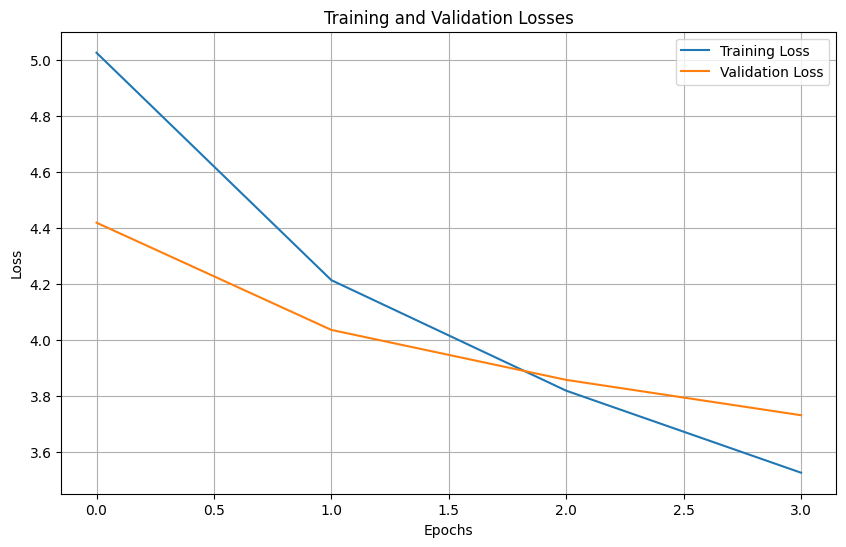

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
sentence = "#Person1#: What does your sister look like, Mike?\n#Person2#: Well, she's tall and pretty.\n#Person1#: Is she like you?\n#Person2#: I suppose so. We're both friendly and easy-going.\n#Person1#: Is she as clever as you?\n#Person2#: No, she's not as clever as me.\n#Person1#: Big head!"
gen_sum, attn_lite = evaluate(encoder_lite, decoder_lite, sentence)

In [ ]:
print(f"Generated Summary by Custom-Lite:\n{' '.join(gen_sum)}")

Generated Summary by Custom-Lite:
#person1# and #person2# are talking about the girl who is not in love with her. <eos>


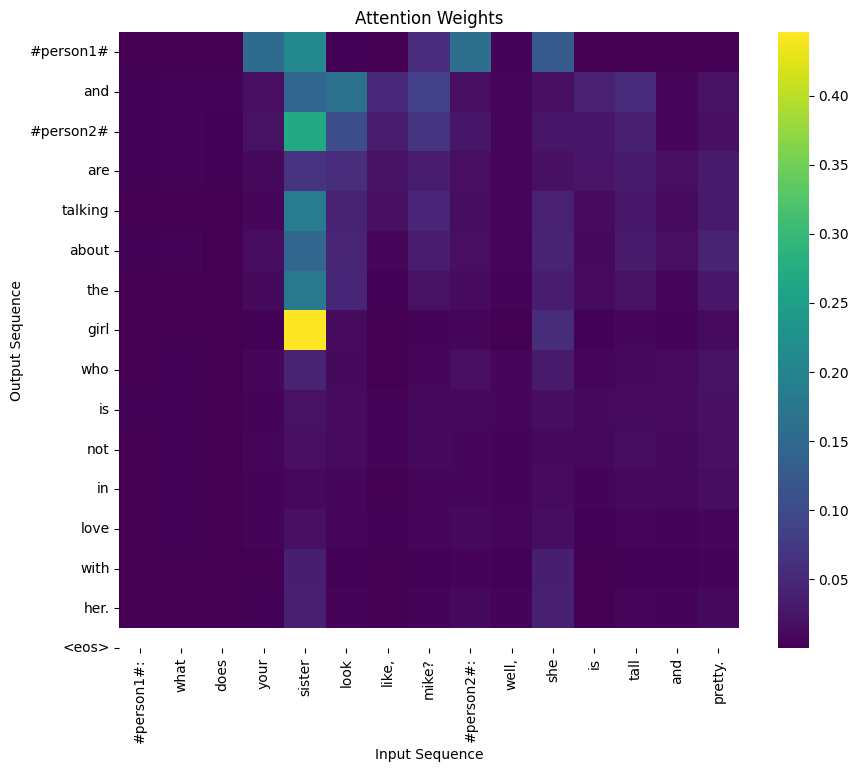

In [ ]:
import seaborn as sns

# Assuming `attention_weights` is your attention tensor, reshaped or squeezed as necessary
attention_weights = attn_lite.squeeze(0).cpu().numpy()[:15, :15]  # Convert to numpy array

# Assuming `input_words` and `output_words` are lists of words in the input and output sequences
input_words = tokenize(sentence)
output_words = gen_sum

# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(attention_weights, xticklabels=input_words[:15], yticklabels=output_words, cmap="viridis")
plt.xlabel('Input Sequence')
plt.ylabel('Output Sequence')
plt.title('Attention Weights')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

In [ ]:
train_losses, val_losses = train(train_dataloader, val_dataloader, encoder_final, decoder_final, 8, 0.001)

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1, Train Loss: 5.586481523513794, Validation Loss: 4.811170518398285
Epoch 2, Train Loss: 4.590988135949159, Validation Loss: 4.339575558900833
Epoch 3, Train Loss: 4.202124774761689, Validation Loss: 4.108392462134361
Epoch 4, Train Loss: 3.9374119844192115, Validation Loss: 3.9775946140289307


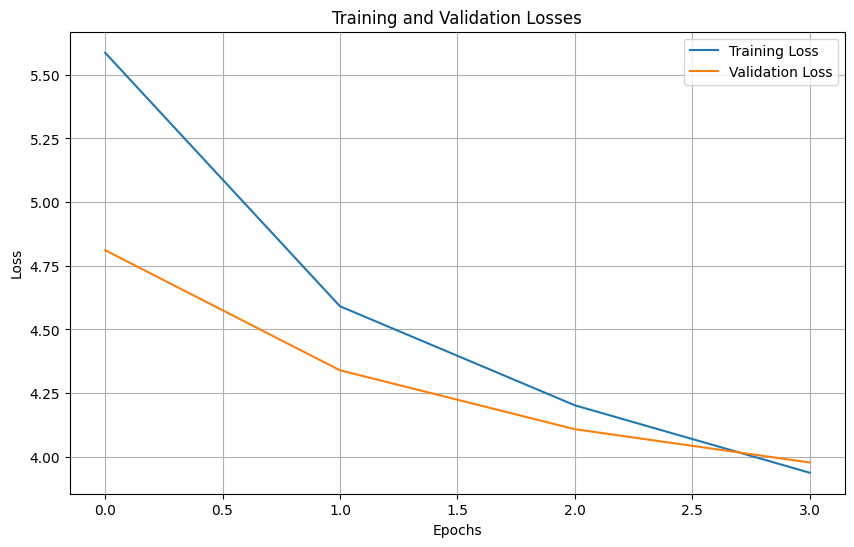

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
sentence = "#Person1#: What does your sister look like, Mike?\n#Person2#: Well, she's tall and pretty.\n#Person1#: Is she like you?\n#Person2#: I suppose so. We're both friendly and easy-going.\n#Person1#: Is she as clever as you?\n#Person2#: No, she's not as clever as me.\n#Person1#: Big head!"
gen_sum, attn_final = evaluate(encoder_final, decoder_final, sentence)

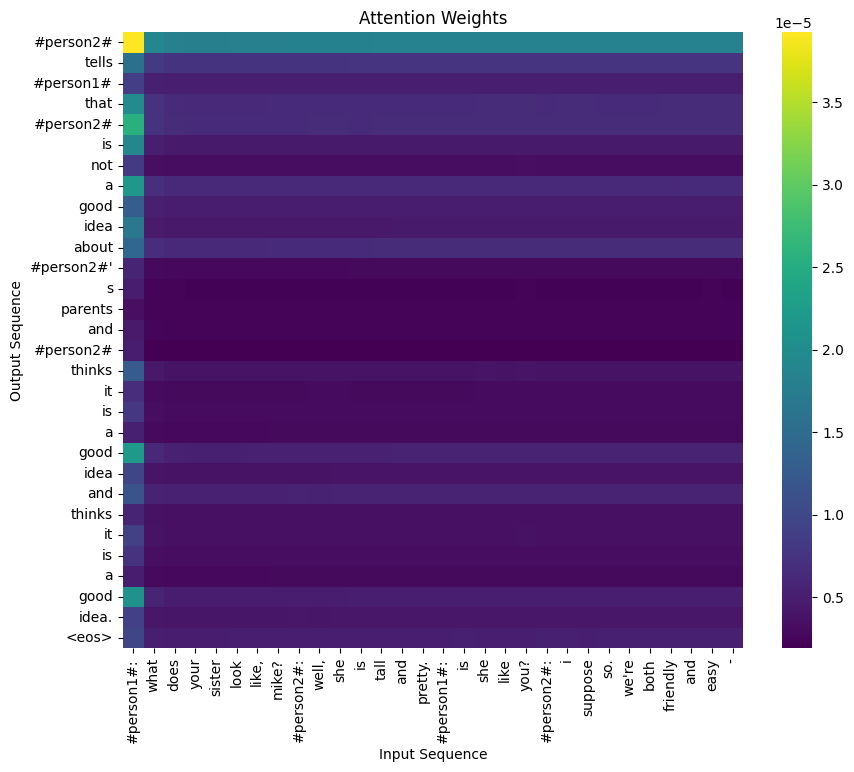

In [ ]:
import seaborn as sns

# Assuming `attention_weights` is your attention tensor, reshaped or squeezed as necessary
attention_weights = attn_final.squeeze(0).cpu().numpy()[:30, :30]  # Convert to numpy array

# Assuming `input_words` and `output_words` are lists of words in the input and output sequences
input_words = tokenize(sentence)
output_words = gen_sum

# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(attention_weights, xticklabels=input_words[:30], yticklabels=output_words, cmap="viridis")
plt.xlabel('Input Sequence')
plt.ylabel('Output Sequence')
plt.title('Attention Weights')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()